In [11]:

############# Typing #############
from typing import Annotated, Sequence, TypedDict

########### OPEN AI ####################
from langchain_core.messages import BaseMessage # Foundational class for all message types in Langgraph
from langchain_core.messages import ToolMessage # Passes data class back to LLM after it calls a tool such as the content and tool call id
from langchain_core.messages import SystemMessage  # Message providing instructions to the LLM
from langchain_core.messages import HumanMessage # Passing HumanMessage
from langchain_core.messages import AIMessage # Message generated by the LLM
from langchain_openai import ChatOpenAI

##### Tools #############
from langchain_core.tools import tool
from langchain_tavily import TavilySearch


######## Langgraph Components #########
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode


######### ENV #########
from dotenv import load_dotenv

In [37]:
load_dotenv()


True

In [38]:
class AgentState(TypedDict):
    ##### HumanMessage and AIMessage --> Datatypes for langchain
    messages : Annotated[Sequence[BaseMessage], add_messages]
    initialize_chat : int


In [39]:
######## Initialize Tools and Models ##########

# list of all tools

tools = [TavilySearch(max_results=5,topic="news")]

##### Model (Binding Tools) #########
llm = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [40]:
def news_agent(state: AgentState) -> AgentState:
    """This node will solve the request you input"""

    
    pass

    # ########## if you are just beginning chat #####
    # if state["initialize_chat"] == 1:
    #     state["messages"] =  [system_prompt] + state["messages"]
    #     state["initialize_chat"] = 0
    #     print(state["messages"])
    #     return state
    
    # else:
    #     state["messages"].append(AIMessage(content=response.content))
    #     return {"messages": [response]}



# AGENT NODE FUNCTION ######
def ReAct(state: AgentState) -> AgentState:

    ####### define system prompt ########
    system_prompt = SystemMessage(content=
   "You are my AI Assistant, please answer my query to the best of your ability")

    
    response = llm.invoke([system_prompt] + state["messages"])
    
    return {"messages": [response]}



In [75]:
#### CONDITIONAL FUNCTIONS ####

def react_function(state: AgentState) -> AgentState:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

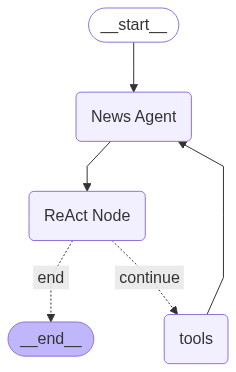

In [91]:
######## GRAPH #######

graph = StateGraph(AgentState)

###### (A) Add nodes ######  

### 1. Chat Nodes ####
graph.add_node("News Agent", news_agent)
graph.add_node("ReAct Node", ReAct)

### 2. Tool Node #####
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)


#### (B) Add edges ######

graph.add_edge(START, "News Agent")


graph.add_edge("News Agent", "ReAct Node")


graph.add_conditional_edges(
    "ReAct Node",
    react_function,
    {
        "continue": "tools",
        "end" : END
    }
)

graph.add_edge("tools", "News Agent")


agent =  graph.compile()
agent

In [81]:
# Helper Function 
def stream_agent(stream, show_stream=True):
    output = []
    for s in stream:
        message = s["messages"][-1]
        if show_stream==True:
            if isinstance(message, tuple):
                print(message)
            else:
                message.pretty_print()
            
        output.append(message)

    return output

In [77]:
inputs = {"messages": [("user",  "What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines")],
          "initialize_chat" : 1}

output = stream_agent(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the latest news? Give me some headlines for this week in United States on - Politics, Sports, Technology, AI. Also provide some context on each of these headlines
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_nsuPrkjjt08bbs3OVD9PmOEF)
 Call ID: call_nsuPrkjjt08bbs3OVD9PmOEF
  Args:
    query: latest news this week United States politics
    search_depth: advanced
    time_range: week
    topic: news
  tavily_search (call_9iIlAn2ux6RHDAHZd1N3293X)
 Call ID: call_9iIlAn2ux6RHDAHZd1N3293X
  Args:
    query: latest news this week United States sports
    search_depth: advanced
    time_range: week
    topic: news
  tavily_search (call_ELxziqF1Wq6QknA5xJiFmmBw)
 Call ID: call_ELxziqF1Wq6QknA5xJiFmmBw
  Args:
    query: latest news this week United States technology
    search_depth: advanced
    time_range: week
    topic: news
  tavi

In [106]:
conversation_history = []
initialize_chat  = 1
user_input = input("Enter: ")
while user_input!= "exit":
    conversation_history.append(HumanMessage(content=user_input))
    print("User: ",user_input)

    inputs = {"messages": [("user", "\n".join([i.content for i in conversation_history]))],
              "initialize_chat" : initialize_chat} 

    result = stream_agent(agent.stream(inputs, stream_mode="values"), show_stream=False)

    print("AI:", result[-1].content)
    
    conversation_history  = [i for i in result if i.type!='tool']

    initialize_chat  = 0
    
    user_input = input("Enter: ")

User:  Hey
AI: Hello! How can I assist you today?
User:  My name is Siddharth
AI: Hello, Siddharth! Nice to meet you. How can I assist you today?
User:  Can you give me some nicknames?
AI: Sure, Siddharth! Here are some nickname suggestions for you:

1. Sid
2. Sidd
3. Siddy
4. Sids
5. Siddhu
6. Siddie
7. Siddo
8. Artie
9. Sidman
10. Hardie

Feel free to choose any that you like! If you have any preferences or themes in mind, let me know and I can suggest more.
User:  What about some news headlines from last week?
AI: Here are some news headlines from last week:

1. **Colorado Suspect Charged with Hate Crime** - A suspect in Colorado has been charged with a hate crime. [Read more](https://www.skynews.com.au/australia-news/todays-news-headlines-colorado-suspect-charged-with-hate-crime/video/3d5f50371f8c7c9fabbc49e577dcea0d)

2. **Erin Patterson Cross-Examined in Court** - Erin Patterson was cross-examined in court as part of ongoing legal proceedings. [Read more](https://www.skynews.com.

In [107]:
with open("outputs/logging.txt", "w") as file:
    file.write("Your Conversation Log:\n")
    
    for message in conversation_history:
        if isinstance(message, HumanMessage):
            file.write(f"You: {message.content}\n")
        elif isinstance(message, AIMessage):
            file.write(f"AI: {message.content}\n\n")
    file.write("End of Conversation")

print("Conversation saved to logging.txt")

Conversation saved to logging.txt
